# Earning Potential and Profit Factors
### How can historical data help estimate future earnings?
### Which variables should be adjusted in order to optimize earning potential?

## 1. Import dependencies and load data

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from datetime import date
import sklearn
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
pd.set_option("display.max_columns", 100)
pd.set_option('max_colwidth',200)

In [74]:
calendar = pd.read_csv("Data/istanbul_calendar.csv")
listings = pd.read_csv("Data/istanbul_listings.csv")

C:\Users\Jeronimo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (43,61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2. Determine which rows are incomplete

Text(0.5, 1.0, 'Incomplete Rows')

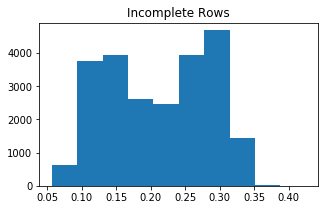

In [75]:
incomplete_rows = listings.isna().mean(axis=1).values
plt.rcParams['figure.figsize'] = (5, 3)
ax = plt.hist(incomplete_rows)
plt.title('Incomplete Rows')

Fortunately, most of the rows, 60-70%, are complete with no missing data. Because the dataset is so vast and only a portion is necessary for the experiment, this is an acceptable rate. 

## 3. Feature engineering
Data will be aggregated from existing columns then appended to new dataframes so they are easily accessible when calculating predictions. 

### 3.1 Generated features

In [76]:
def lower(s):
    try:
        return s.lower()
    except:
        return s

def perc_to_numbers(p):
    '''
    "30%" --> 0.3
    '''
    try:
        return float(p.split("%")[0])/100
    except:
        return float("nan")

In [77]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,4826,https://www.airbnb.com/rooms/4826,20200322144100,2020-03-23,The Place,My place is close to great views. My place is good for couples and business travelers.,A double bed apartment on the Asian side of Istanbul. Neat and a comfortable place with a great Bosphorus view. A Balcony to enjoy sunset drinks. Walking distance to the pier for a 20min. boat rid...,My place is close to great views. My place is good for couples and business travelers. A double bed apartment on the Asian side of Istanbul. Neat and a comfortable place with a great Bosphorus vie...,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/15347/ba878c62_original.jpg?aki_policy=large,NaN,6603,https://www.airbnb.com/users/show/6603,Kaan,2009-01-14,"Istanbul, Istanbul, Turkey","Hello...\r\nI am Kaan and I am from Istanbul, Turkey. I am the founder of a digital advertising agency called Workattack.\r\nI am looking forward to meet young professionals who will share the fun...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/6603/profile_pic/1259098055/original.jpg?aki_policy=profile_small,https://a0.muscache.com/im/users/6603/profile_pic/1259098055/original.jpg?aki_policy=profile_x_medium,Üsküdar,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Istanbul Province, Istanbul, Turkey",Üsküdar,Uskudar,NaN,Istanbul Province,Istanbul,34684,Istanbul,"Istanbul Province, Turkey",TR,Turkey,41.05650,29.05367,...,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Smoking allowed"",""Pets allowed"",Breakfast,Heating,""Family/kid friendly"",Washer,Dryer,Essentials}",700.0,$688.00,NaN,NaN,NaN,NaN,2,$170.00,1,730,1,1,730,730,1.0,730.0,35 months ago,t,30,60,90,365,2020-03-23,1,0,2009-06-01,2009-06-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,1,0,0,0.01
1,20815,https://www.airbnb.com/rooms/20815,20200322144100,2020-03-23,The Bosphorus from The Comfy Hill,"Watch The Bosphorus from The Comfy Hill. A spacious and relaxing place with a wide view of the Bosphorus, two rooms, an open kitchen, and a single rule to feel home.","The low green hills of Arnavutköy, the lovely, peaceful and quiet neighborhood in the high-society area of the city, directly facing the Bosphorus, host this house on one of its safest streets. A...","Watch The Bosphorus from The Comfy Hill. A spacious and relaxing place with a wide

In [78]:
summary = listings['neighbourhood_cleansed'].apply(lower)
#beyoglu = listings.loc[listings['neighbourhood_cleansed'] == 'Beyoglu']
host_age = listings['host_since'].apply(lambda x: (datetime.datetime.today() - pd.to_datetime(x)).days/30)
reponse_rate = listings['host_response_rate'].apply(perc_to_numbers)
acceptance_rate = listings['host_acceptance_rate'].apply(perc_to_numbers)

In [79]:
listings[['host_total_listings_count']].describe()

,host_total_listings_count
count,23457.000000
mean,16.236859
std,127.656425
min,0.000000
25%,1.000000
50%,1.000000
75%,5.000000
max,1467.000000


In [80]:
print("{:.2%} of the hosts have no more than 2 listings, {:.2%} of the hosts have more than 10 listings"\
.format(sum(listings['host_total_listings_count']<=2)/len(listings), sum(listings['host_total_listings_count']>10)/len(listings)))

62.90% of the hosts have no more than 2 listings, 11.99% of the hosts have more than 10 listings


Creating 3 groups based on how many listings hosts control.

In [81]:
one_or_two_listings = listings['host_total_listings_count'] <= 2 
three_to_ten_listings = (listings['host_total_listings_count'] > 2) & (listings['host_total_listings_count'] < 10)
more_than_ten_listings = listings['host_total_listings_count'] > 10

In [82]:
response_time_dict = {
    'a few days or more':1,
    'within a day': 2,
    'within a few hours': 3,
    'within an hour': 4
}

C:\Users\Jeronimo\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Jeronimo\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1789., 1294.,  715., 1212., 1113.,  685.,  422.,  168.,   38.,
           3.]), array([  1.8       ,  15.41333333,  29.02666667,  42.64      ,
         56.25333333,  69.86666667,  83.48      ,  97.09333333,
        110.70666667, 124.32      , 137.93333333]), <a list of 10 Patch objects>)

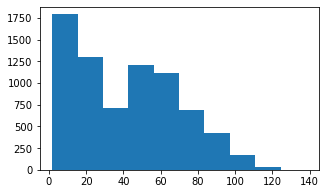

In [83]:
plt.hist(host_age[listings['host_response_time'].isna()])

Some listings don't have a host response time entered. Those will be added to the most popular response time so to keep the data relevant.

In [84]:
response_time_ordinal = listings['host_response_time']\
                        .fillna("within a few hours").apply(lambda x: response_time_dict[x])

In [85]:
real_bed = listings['bed_type'] == "Real Bed"
popular_neighborhoods = list(listings\
                        .groupby('neighbourhood_cleansed')\
                        .count()['id'].sort_values(ascending=False)[:10].index)
neighborhoods_one_hot = pd.get_dummies(listings[['neighbourhood_cleansed']])
amenities_len = listings['amenities'].apply(len)
cancellation_policy_dict = {
    'flexible': 1,
    'moderate': 2,
    'strict': 3,
    'strict_14_with_grace_period': 4,
    'super_strict_30': 5,
    'super_strict_60': 6
}
cancellation_policy_ordinal = listings['cancellation_policy']\
                              .fillna("super_strict_60").apply(lambda x: cancellation_policy_dict[x])

In [86]:
final_df = pd.DataFrame({
    'id': listings['id'],
    #'beyoglu': beyoglu,
    'host_age': host_age,
    'reponse_rate': reponse_rate,
    'acceptance_rate': acceptance_rate,
    'one_or_two_listings': one_or_two_listings,
    'three_to_ten_listings': three_to_ten_listings,
    'more_than_ten_listings': more_than_ten_listings,
    'response_time_ordinal': response_time_ordinal,
    'real_bed': real_bed,
    'amenities_len': amenities_len,
    'cancellation_policy_ordinal': cancellation_policy_ordinal
}).join(neighborhoods_one_hot)

### 3.2 Binary columns

In [87]:
def convert_binary(x):
    try:
        return 1 if x == "t" else 0
    except:
        return 0

In [88]:
binary_pd = listings[['host_is_superhost',
              'host_has_profile_pic',
              'host_identity_verified',
              'is_location_exact',
              'requires_license',
              'instant_bookable',
              'require_guest_profile_picture',
              'require_guest_phone_verification']].applymap(convert_binary)

In [89]:
final_df = final_df.join(binary_pd)

### 3.3 Money string conversion to numbers

In [90]:
def convert_money(s):
    '''
    "$250.00" --> 250
    '''
    try:
        return float(eval(s.split("$")[1]))
    except:
        return float("nan")

In [91]:
money_pd = listings[['price','extra_people']].applymap(convert_money)

In [92]:
final_df = final_df.join(money_pd)

### 3.4 Add `price_per_bed_compared_to_nbh`
What's the difference between listing bed prices and neighborhood bed prices?

In [93]:
listings['price_num'] = final_df['price']
listings['price_per_bed'] = listings['price_num'] / listings['beds'].replace(0,1)
avg_price_per_bed = listings.groupby('host_neighbourhood')['price_per_bed'].mean().reset_index()\
                              .rename({'price_per_bed':'price_per_bed_nbh'}, axis=1)
listings = listings.merge(avg_price_per_bed, on="host_neighbourhood")
listings['price_per_bed_compared_to_nbh'] = listings['price_per_bed'] - listings['price_per_bed_nbh']

Text(0.5, 1.0, 'Listing Bed Price vs Neighborhood Average')

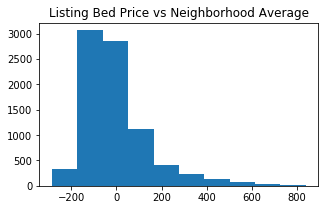

In [94]:
x = plt.hist(listings['price_per_bed_compared_to_nbh'])
plt.title('Listing Bed Price vs Neighborhood Average')

### 3.5 Add other numeric columns and id column

In [95]:
final_df = final_df.join(listings[[
                                   'accommodates',
                                   'bathrooms',
                                   'bedrooms',
                                   'beds',
                                   'number_of_reviews',
                                   'review_scores_rating',
                                   'review_scores_accuracy',
                                   'review_scores_cleanliness',
                                   'review_scores_checkin',
                                   'review_scores_communication',
                                   'review_scores_location',
                                   'review_scores_value',
                                   'price_per_bed_compared_to_nbh'
                                   ]])

### 3.6 Deal with missing values

In [96]:
m = final_df.isna().sum()
m[m>0]

host_age                            13
reponse_rate                      7452
acceptance_rate                   7468
price                             1293
extra_people                        13
accommodates                     14501
bathrooms                        14533
bedrooms                         14525
beds                             14615
number_of_reviews                14501
review_scores_rating             17835
review_scores_accuracy           17841
review_scores_cleanliness        17838
review_scores_checkin            17840
review_scores_communication      17838
review_scores_location           17839
review_scores_value              17840
price_per_bed_compared_to_nbh    15196
dtype: int64

#### 3.6.1 Specify which columns NaN to 0 conversion

In [97]:
final_df[['price_per_bed_compared_to_nbh',
            'number_of_reviews']] = final_df[['price_per_bed_compared_to_nbh','number_of_reviews']].fillna(0)

#### 3.6.2 Columns that need be filled with the means

In [103]:
final_df_sub1 = final_df[['reponse_rate',
                  'review_scores_rating',
                  'review_scores_accuracy',
                  'review_scores_cleanliness',
                  'review_scores_checkin',
                  'review_scores_communication',
                  'review_scores_location',
                  'review_scores_value']].copy()

final_df[['reponse_rate',
          'review_scores_rating',
          'review_scores_accuracy',
          'review_scores_cleanliness',
          'review_scores_checkin',
          'review_scores_communication',
          'review_scores_location',
          'review_scores_value']] = pd.DataFrame(SimpleImputer(missing_values=float('nan'), 
          strategy="mean", 
          fit_transform(final_df_sub1), 
          columns = final_df_sub1.columns)

SyntaxError: unexpected EOF while parsing (<ipython-input-103-1581de8aa69c>, line 18)